In [2]:
import numpy as np


np.random.seed(0)


# https://towardsdatascience.com/stochastic-processes-simulation-the-ornstein-uhlenbeck-process-e8bff820f3

In [3]:
class BrownianMotion:
    
    def __init__(self, mean=0.0, std_dev=1.0):
        self.mean = mean
        self.std_dev = std_dev
        
    def dW(self, num_samples):
        return np.random.normal(loc=self.mean, scale=self.std_dev, size=num_samples)
    
    def W(self, num_samples):
        dW = self.dW(num_samples)
        
        # Integrate by cumulative sum
        dW_sum = dW.cumsum()
        
        # Prepend W(0) = 0 and trim to `num_samples`.
        return np.insert(dW_sum, 0, 0)[:-1]

(array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.]),
 [Text(0, -10.0, '−10'),
  Text(0, -5.0, '−5'),
  Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35')])

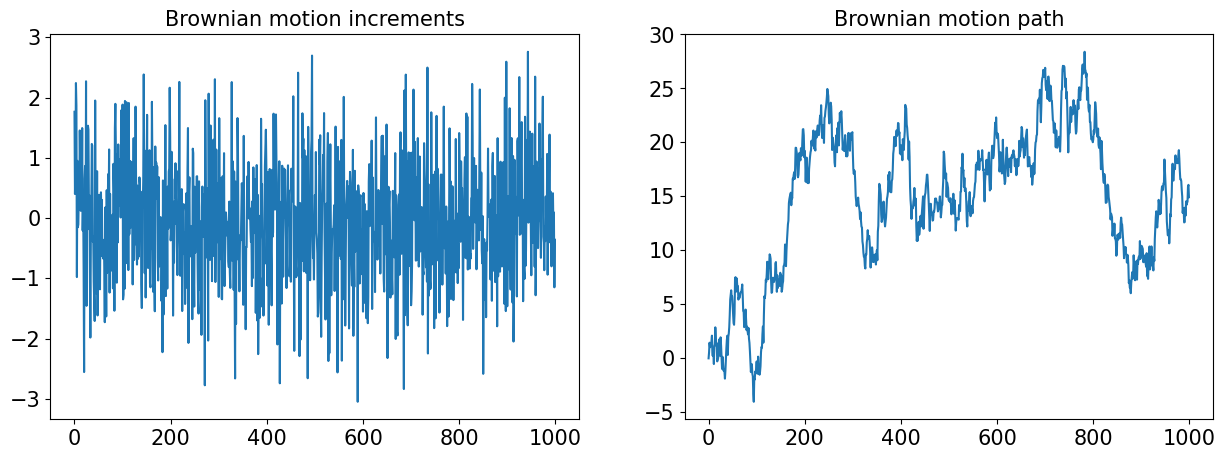

In [4]:
bm = BrownianMotion()

dW = bm.dW(num_samples=1000)
W = bm.W(num_samples=1000)

#----------------------------------------------------------------
# plot

import matplotlib.pyplot as plt 
import seaborn as sns


fig = plt.figure(figsize=(15, 5))

title = "Brownian motion increments"
plt.subplot(1, 2, 1)
plt.plot(dW)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Brownian motion path"
plt.subplot(1, 2, 2)
plt.plot(W)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [5]:
class OrnsteinUhlenbeck(BrownianMotion):
    
    def __init__(self, alpha, beta, gamma, X_0, mean=0.0, std_dev=1.0):      
        """
        
        :param alpha: mean reversion parameter
        :param beta: asymptotic mean
        :param gamma: scale of Brownian motion (std dev)
        :param X_0: initial value. Free to choose any.
        
        Examples of X_0 choices:
            - Long term mean (gamma).
            - Most recent data point.
            
        In general:     X_t = X_0*exp(-alpha * t) + gamma*(1 - exp(-alpha * t)) + beta * exp(-alpha * t)*W
        If X_0 = gamma: X_t = gamma + beta * exp()-alpha * t * W
        """
        super().__init__(mean, std_dev)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.X_0 = X_0
        
    def __call__(self, num_samples: int):
        # Construct vector of time steps for each sample data point.
        t = np.arange(num_samples)
        dW = self.dW(num_samples)        
        
        # Integrate with respect to Brownian Motion (W), ∫...dW.
        exp_alpha_s = np.exp(self.alpha * t)
        W = np.cumsum(exp_alpha_s * dW)
        W = np.insert(W, 0, 0)[:-1]  # Enforce W(0)=0.
        
        exp_alpha_t = np.exp(-self.alpha * t)
        
        return self.X_0*exp_alpha_t + self.gamma * (1 - exp_alpha_t) + self.beta * exp_alpha_t * W

In [6]:
ou = OrnsteinUhlenbeck(alpha=0.07, beta=0.001, gamma=0.0)
process = ou(num_samples=1000)

(array([-0.01 , -0.008, -0.006, -0.004, -0.002,  0.   ,  0.002,  0.004,
         0.006,  0.008]),
 [Text(0, -0.01, '−0.010'),
  Text(0, -0.008, '−0.008'),
  Text(0, -0.006, '−0.006'),
  Text(0, -0.004, '−0.004'),
  Text(0, -0.002, '−0.002'),
  Text(0, 0.0, '0.000'),
  Text(0, 0.002, '0.002'),
  Text(0, 0.004, '0.004'),
  Text(0, 0.006, '0.006'),
  Text(0, 0.008000000000000002, '0.008')])

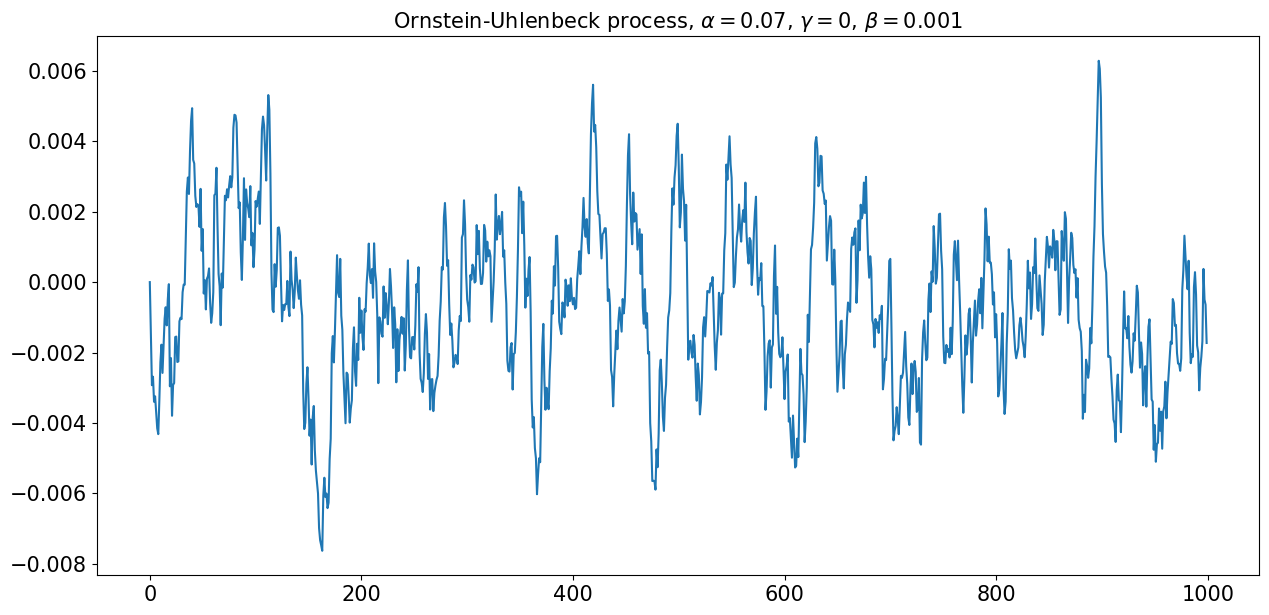

In [7]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15, 7))

title = "Ornstein-Uhlenbeck process, "
title += r"$\alpha=0.07$, $\gamma = 0$, $\beta = 0.001$"
plt.plot(process)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [8]:
# From 3.

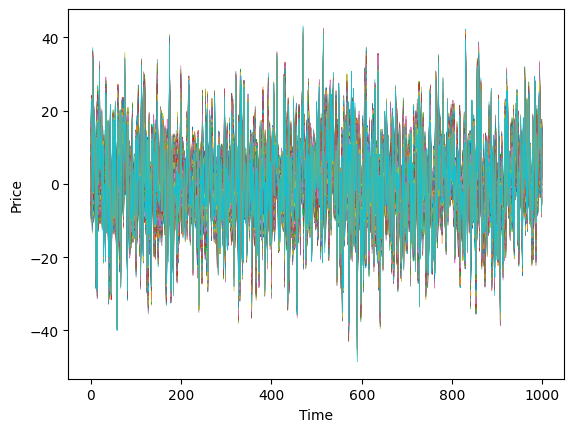

In [25]:
num_timesteps = 200
t = np.linspace(0, num_timesteps-1, num_timesteps)
dt = np.mean(np.diff(t))

num_sims = 1000

y0 = process[-1]


# Careful, this alpha is not the alpha above!
# alpha = ou.gamma
alpha = -(ou.beta**2)/(2*ou.alpha)  # ou.alpha is k in 3.


def mc(num_timesteps, k, alpha, t):
    paths = [y0]
    bm_rets = ou.dW(num_timesteps)
    
    for i in range(0, num_timesteps-1):
        drift = k*(alpha-paths[i])*dt
        rand = bm_rets[i]

        path = paths[i] + drift + rand
        paths.append(path)
    
    return paths


# paths = np.asarray([mc(num_timesteps, ou.alpha, alpha, t) for _ in range(num_sims)])
paths = np.asarray([ou.W(num_timesteps) for _ in range(num_sims)])

int_path = np.exp(paths.T)

plt.plot(paths, lw=0.5)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()